# Estimating Train Volumes from InDOT Rail Preemption Data

This notebook outputs train_volumes.parquet which is the estimated annual train volumes at each InDOT traffic signal with a train crossing.

In [1]:
# !pip install duckdb
import duckdb

# load data
signals = duckdb.sql("SELECT * FROM 'data/signals.parquet'").df()
events = duckdb.sql("SELECT * FROM 'data/events.parquet'").df()


In [2]:
signals.head()

,signal_id,commission_nbr,location,latitude,longitude
0,47,01-032-077,SR 67 at Mooresville Rd,39.646620,-86.329085
1,77,01-079-143,US 231 at Airport Rd,40.417979,-86.930510
2,95,01-082-127,SR 57 at Boonville/New Harmony Rd,38.085599,-87.494881
3,454,01-010-034,SR 31 @ CHARLESTOWN / NA PIKE,38.320351,-85.751570
4,459,01-010-040,US 31 @ SR 403,38.405910,-85.752930


In [3]:
events.head()

,event_timestamp,event_code_id,event_param,signal_id
0,2024-01-10 12:38:09.300,104,15,47
1,2024-01-10 12:38:09.300,104,16,47
2,2024-01-10 12:38:09.300,104,3,47
3,2024-01-10 12:38:09.300,104,4,47
4,2024-01-10 12:38:09.300,104,6,47


Event codes can be found at: https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1003&context=jtrpdata

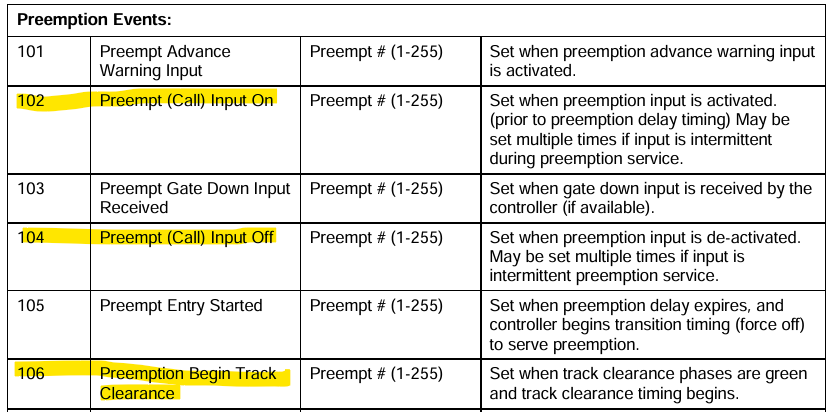

The first problem with our dataset is that we have preemption events from emergency vehicles (firetrucks) mixed in with preemption events from trains. However, when a train preempt occurs, it comes with a distinct event code, 106, Preemption Begin Track Clearance. We can use this to filter out the emergency vehicle preempts.

If we only use event 106 we could get train counts, but if we use event 102 and 104 together then we can also get the preempt duration, which indicates how long it took the train the cross the intersection. For simplicity, we can just filter to event 106 to work on getting train counts, and come back to add the duration later as if needed.


In [4]:
filtered_events = duckdb.sql("""
SELECT signal_id, event_timestamp as preempt_time FROM events
WHERE event_code_id = 106
""").df()

filtered_events

,signal_id,preempt_time
0,47,2024-01-11 10:52:13.300
1,47,2024-01-16 10:36:37.400
2,47,2024-01-18 10:25:26.100
3,47,2024-01-24 10:13:13.300
4,47,2024-01-25 10:05:39.900
...,...,...
222611,5919,2024-07-03 20:11:25.100
222612,5919,2024-07-03 23:28:18.400
222613,5919,2024-07-04 11:09:49.200
222614,5919,2024-07-05 02:28:59.900


We do need to do a quick check for equipment failures, which can result in erratic preemption events. To do this, we will aggregate counts per signal by day and check for outliers.

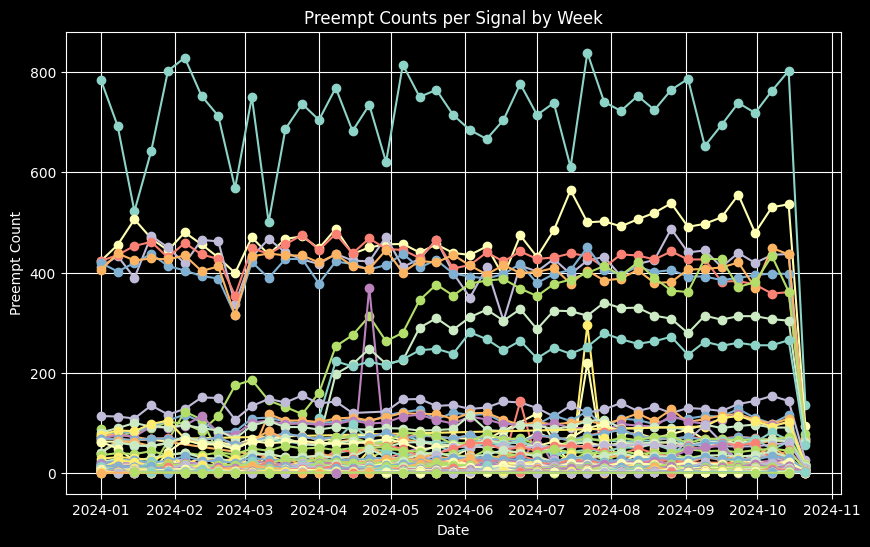

In [5]:
# Aggregate counts per signal by day
sql = """
SELECT signal_id, time_bucket(INTERVAL 1 WEEK, preempt_time) as week, count(*) as preempt_count
FROM filtered_events
GROUP BY ALL
ORDER BY preempt_count DESC
"""

weekly_counts = duckdb.sql(sql).df()

# Plot counts per signal by day
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot each signal_id as a separate series
for signal_id in weekly_counts['signal_id'].unique():
    signal_data = weekly_counts[weekly_counts['signal_id'] == signal_id]
    signal_data = signal_data.sort_values('week')
    plt.plot(signal_data['week'], signal_data['preempt_count'], marker='o', linestyle='-')

plt.title('Preempt Counts per Signal by Week')
plt.xlabel('Date')
plt.ylabel('Preempt Count')
plt.grid(True)
plt.show()

There is an obvious outlier, the one regularly showing over 600 preempts per week. It is at the intersectino of CR 28 (Peddlers Village Rd) and Highway 33. There are three tracks that cross over this intersection, and it is next to a rail yard, which explains the high numbers. See the map below for more context. 

It is also apparent that some locations had preempt counts increase over the course of the past year. This indicates changes in train traffic, and tells us that we will need to periodically update our dataset as these changes occur.

There are also a few temporary spikes, which are likely due to equipment failures. To prevent equipment failures from skewing our data, we will come up with an annual estimate by taking the weekly median count and multiplying by 52.

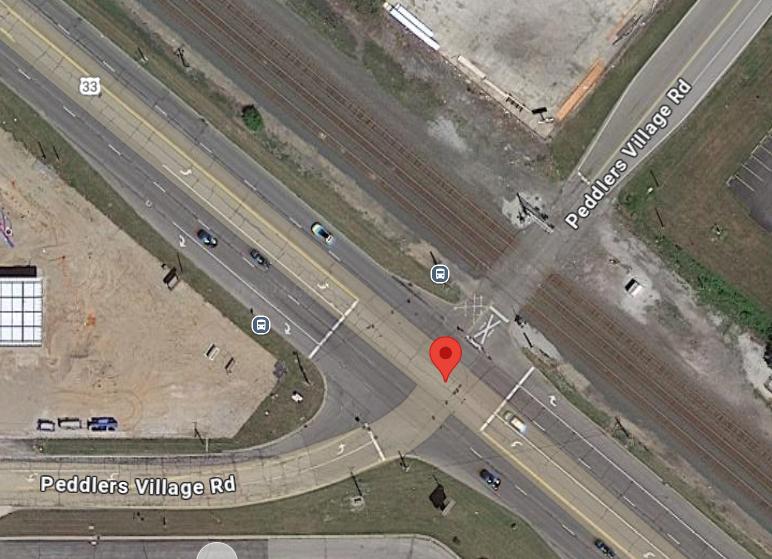

In [6]:
# Calculate Weekly Median and Annual Estimate and Join with Signals
sql = """
SELECT
    location,
    latitude,
    longitude,
    median(preempt_count)::INT * 52 as annual_estimate
FROM weekly_counts
NATURAL JOIN signals
GROUP BY ALL
ORDER BY annual_estimate
"""

train_volumes = duckdb.sql(sql).df()

# Save the output
duckdb.sql("COPY train_volumes TO 'data/train_volumes.parquet'")

train_volumes

,location,latitude,longitude,annual_estimate
0,SR 67 at Mooresville Rd,39.646620,-86.329085,104
1,US 50 & Agrico,38.958050,-85.862600,156
2,"SR 67 & Mendenhall Rd, Heathrow Way",39.679729,-86.288353,208
3,US 31(MORTON) @ SR 44(JEFFERSON),39.480141,-86.064060,208
4,US 50 & Stevens Way,38.958210,-85.837680,208
...,...,...,...,...
63,SR 933(Lincolnway E.) @ Russell Ave.,41.657750,-86.210594,21424
64,SR 933 (Lincolnway E.) @ Ash Rd.,41.664108,-86.061065,22100
65,US 33 & CR 15,41.626728,-85.906687,22568
66,US 33 & Concord Mall/Sunnyside Dr,41.642238,-85.928079,24336
